* This notebook can also available in [kaggle](https://www.kaggle.com/sapal6/can-we-use-a-network-to-understand-data)
* Get the code used in this note book on [github](https://github.com/sapal6/kaggle_competitions/tree/main/happywhale).
* The data used can be found [here](https://www.kaggle.com/rdizzl3/jpeg-happywhale-128x128) 

## What is this ?
* A starter notebook for folks new to machine learning.
* A vanilla CNN created for [whale species recognition](https://www.kaggle.com/c/happy-whale-and-dolphin) competition using fastai.
* Aim is to observe the behavior of a simple CNN trained to recognize the whale species.
* Here I am trying to show that you can use a simple CNN to know what areas of an image does the CNN "sees". You can use this to analyze what needs to be improved or engineered in the data to create a better model.

## Import required things.

In [2]:
from fastai.vision.all import *

### Required paths

In [3]:
root_path = Path("../input")
train_csv_path = root_path/'happy-whale-and-dolphin/train.csv'
train_img_path = root_path/"jpeg-happywhale-128x128/train_images-128-128/train_images-128-128"

## Get a glimpse of the files
`get_image_files` is a convenience function that goes through different folders and subfolders and gathers all the image file path.

In [4]:
train_imgs = get_image_files(train_img_path)
train_imgs[:10]

(#10) [Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/80b5373b87942b.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/e113b51585c677.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/94eb976e25416c.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/19a45862ab99cd.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/be9645065510e9.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/76d25044120d3c.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/0c64a705ba5d31.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/c1fe278bdbd837.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/6f94f30ac500a0.jpg'),Path('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-12

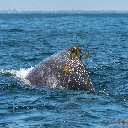

In [5]:
Image.open(train_imgs[1])

let's see what is there in the csv file.

In [6]:
train_path_df = pd.read_csv(train_csv_path)

In [7]:
train_path_df.head(5)

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


If I can catch hold of the image filename from the dataframe and attach this to the `train_img_path` then I can get the full image path.

Replacing filnames with the filepath

In [8]:
train_path_df['image'] = train_path_df['image'].apply(lambda x:train_img_path/x)

In [9]:
train_path_df.head(2)

,image,species,individual_id
0,../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/000562241d384d.jpg,humpback_whale,1a71fbb72250


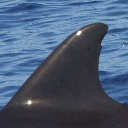

In [10]:
Image.open(train_path_df.image[0])

## Datablock
A `DataBlock` is like a blueprint that tells fastai-->
* What kind of data are we dealing with. Is it image, text etc.
* What kind of labels we have. For example categorical labels, continuous labels etc.
* From where to get the inputs.
* From where to get the targets.
* How to split the data into train and test.
* The transforms that you want to do.

In [11]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                splitter=TrainTestSplitter(),
                 get_x = ColReader(0),
                 get_y = ColReader(1),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=128))

In the above code--> 
* The `ImageBlock`  tells fastai that we are dealing with image data.
* `CategoryBlock` means our targets are categorical in nature.
* The  `get_x` and `get_y` tells fastai to get the x i.e. the image path from column 0 of dataframe and the target from column 1 of the dataframe.
* `splitter` is the way in which train and test data are split. check [here](https://docs.fast.ai/data.transforms.html#TrainTestSplitter) for more details.
* The next two lines are not that important to understand now but they are needed when you are working on image augmentation. Refer to the [fastbook](https://github.com/fastai/fastbook) to understand more about this.

In [12]:
# this is not necessary. I was just testing if my datablocks are correct or not
#data.summary(train_path_df)

## Dataloader
Think of a dataloader as a mechanism that picks up your images, does all the things that you had described in the datablock and then loads your data to the device(cpu or gpu).

At the minimum, you need to provide the source of data, the `train_path_df` in our case. Here we give the `bs` i.e. the batch size. For example if we say that the batch size is 8 then it means that the dataloader will load 8 images at a time onto the device.

In [13]:
dls = data.dataloaders(train_path_df, bs=128)

/root/.local/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


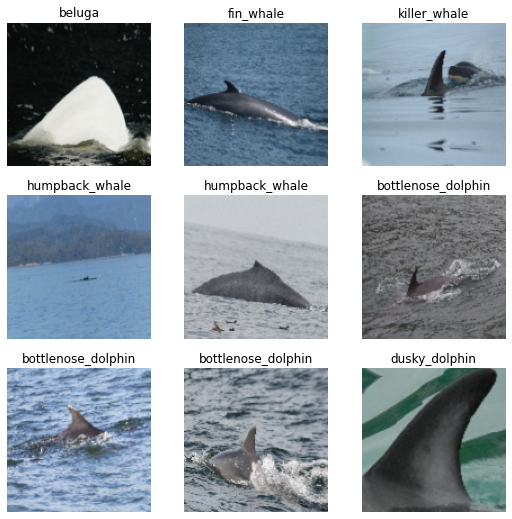

In [14]:
dls.show_batch()

## The model

Simple CNN to classify whale/dolphin species. The intuition is the following-->
* a model which knows to recognize whale/dolphin species should also be able to learn the features to distinguish the different species.
* such a model can be queried to learn what all portions of an image is taken into account. For example, if somehow the background is tricking the model such that the model considers the background as an area of interest then such data needs to be further engineered.

* such model can then be used as a pre-trained model to recognize individuals .

## Creating a simple CNN learner
`cnn_learner` creates a convolutional neural network for you. At the least you provide it the dataloader, a model architecture and a loss function.

`models.resnet18` is a "pre-trained" neural network. It's a network that was already trained by some good folks (folks with huge computational hardware) on a very large  number of images. This particular network knows how to recognize different images. So, we take this network and then ask fastai to train this network on our image data (whale, dolphins). 

The intuition is that since the pre-trained network already knows how to distinguish between different images, we have to spend less time and computation to make it understand how to recognize different whales and dolphins. This is **Transfer learning**

In [15]:
learn = cnn_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), ps=0.25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/root/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


For now understand that `fine_tune` means "take my network and make it look at each image a specified number of times. This "number of times" is the number that is provided as the first argument.

Let's not dive into the second argument at this moment in time.

> For the curious mind, the second argument is known as the learning rate. It's a hyperparameter of a neural network. More information can be found [here](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

In [16]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,time
0,0.905516,0.673760,03:58


epoch,train_loss,valid_loss,time
0,0.422199,0.337718,02:24
1,0.231187,0.232147,02:24


We can see what the model predicted vs the actual target.

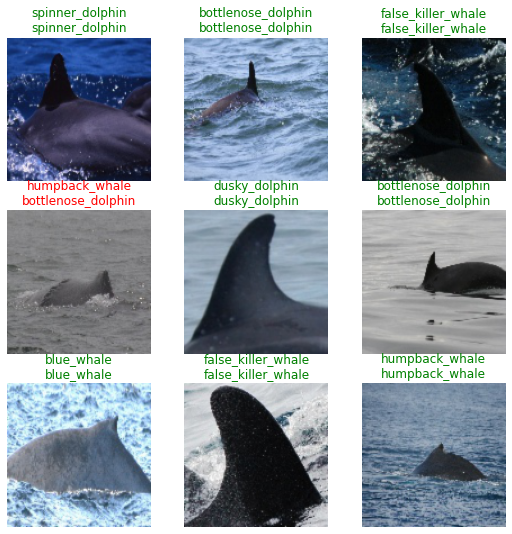

In [17]:
learn.show_results()

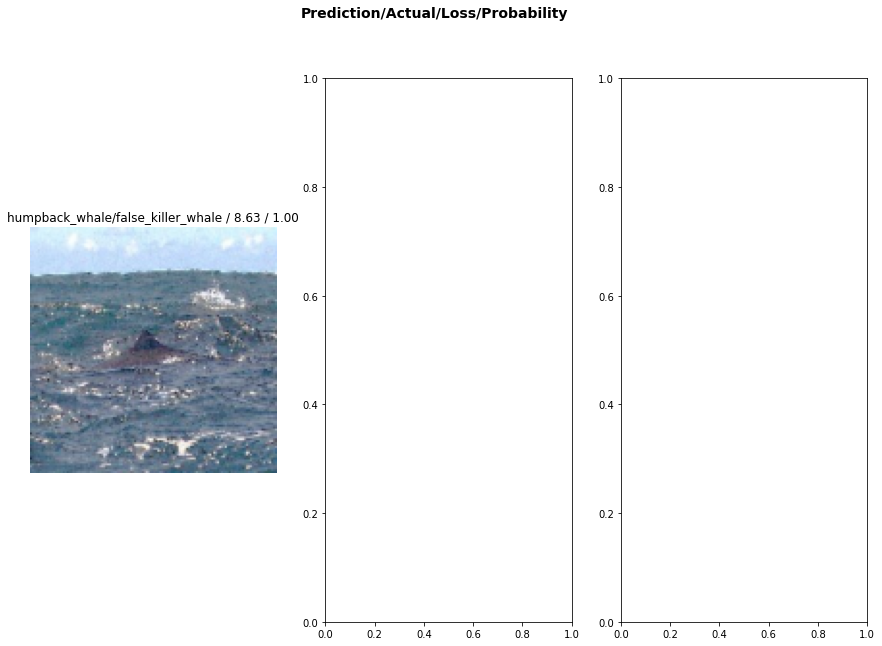

In [18]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(15,10))

## Why the neural network makes the decision?
We can use class activation maps (CAM) to see which regions of images are of interest to the neural network. Class activation map (CAM) was first introduced by Bolei Zhou et al. in ["Learning Deep Features for Discriminative Localization"](https://arxiv.org/abs/1512.04150). Cam uses the output of the last convolutional layer with the predictions to give a heatmap of the regions of interest of the network in an image.

The intuition behind CAM is that if we do the dot product of the activations of the final layer with the final weights, for each location on our feature map then we can get the score of the feature that was used to make a decision. 

Pytorch provides hooks to hook onto the any layer of a network. We can attach a hook to any layer of a neural network and it will be executed during the forward pass i.e. the moment when the output is computed or during the backward pass i.e. the moment when the weights are being re-adjusted.

I would highly recommend to read more about CAM in this chapter of [fastbook](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb) before proceeding on with the code.

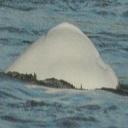

In [19]:
Image.open(train_path_df.image[6])

Let's grab a batch.

In [20]:
img = PILImage.create(train_path_df.image[6])
# grab a batch
x, = first(dls.test_dl([img]))

We hook into the network . A forward hook takes into three things --> the model , its input and it's output. The fourth line in the below code is the hook function.


In [21]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

Now we do the dot product of our weight matrix  with the activations.

The code below takes the model, hooks into the last layer of our model using our hook function and stores the activations in the `act` variable. Then we do the dot product of the stored activations with the weights using `torch.einsum`.

In [22]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): 
        output = learn.model.eval()(x.cuda())
        act = hook.stored[0]
    cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
    cam_map.shape

For each image in our batch, and for each class, we get a 7×7 feature map that tells us where the activations were higher and where they were lower. This will let us see which areas of the pictures influenced the model's decision.

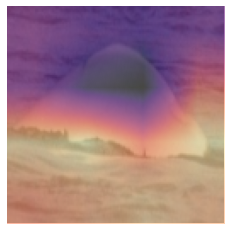

In [23]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,128,128,0),
              interpolation='bilinear', cmap='magma');

The bright areas in the activations are somehow spilling over to the ocean. In my opinion this should not be the case. The activations should be more around the of the dorsal fins and the surface of the fin. In layman terms the network should focus more on the object i.e. the fin features and not on the surrounding water.

An important takeaway from my perspective is that if we can restrict the region of interest to the whale fin and not the surrounding water then the network would be able to learn better.

## Conclusion
Besides tasks like classifying images or detecting objects, a neural networks can be used for analyzing the data to device strategies for pre-processing, data engineering and data cleaning. 

Here I have bounced off one idea about how a simple CNN can be used to understand the regions in an image that the neural network focuses to make it's decisions and then analyzing these things we can observer if the network is focusing on areas of images that it needs to focus and if not, then we can think of the steps that we can take to help the network to focus to generalize better.

I have just scratched the surface of what's possible here and there can be many more ways in which deep learning can be used to take better decisions on data. So, I would emphasize you to expand on this idea and think of other ways in which you can use simple networks to analyze the data before building an architecture for the actual task at hand.